In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import warnings
warnings.filterwarnings('ignore')

2024-03-20 22:59:32.209490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 22:59:32.209589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 22:59:32.401601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import cv2
import numpy as np

def import_images(root_folder, image_size=(224, 224)):
    image_data = []
    labels = []
    
    for label in os.listdir(root_folder):
        label_folder = os.path.join(root_folder, label)
        if os.path.isdir(label_folder):
            for image_file in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_file)
                if image_file.endswith('.jpg' or '.jpeg' or '.png'):
                    try:
                        image = cv2.imread(image_path)
                        image = cv2.resize(image, image_size)  # Resize image if needed
                        image_data.append(image)
                        if label=='no':
                            label=0
                        else:
                            label=1
                        labels.append(int(label))  # Assuming folder names are labels
                    except Exception as e:
                        print(f"Error importing image {image_file}: {e}")
    
    image_data = np.array(image_data)
    labels = np.array(labels)
    
    return image_data, labels

root_folder = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
images, labels = import_images(root_folder)

# Now you have your images and corresponding labels as numpy arrays


In [4]:
x = images

In [5]:
y = labels

0


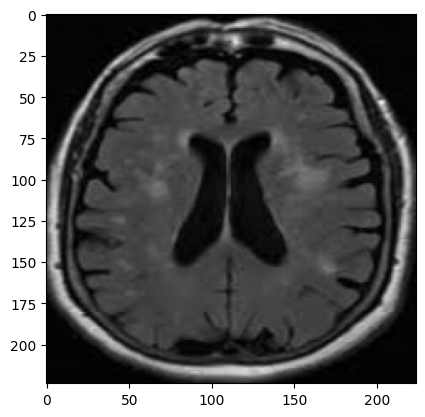

In [6]:
plt.imshow(images[0])
print(labels[0])

1


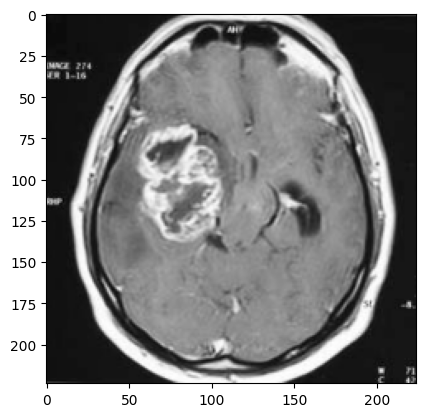

In [7]:
plt.imshow(x[100])
print(y[100])

In [8]:
x.shape

(171, 224, 224, 3)

In [9]:
y.shape

(171,)

In [10]:
xx,xtest,yy,ytest = train_test_split(x,y,test_size=0.3,shuffle=True,random_state=101)

In [11]:
xtrain,xval,ytrain,yval = train_test_split(xx,yy,test_size=0.2,shuffle=True,random_state=101)

In [12]:
mymodel = models.Sequential([
    layers.Input(shape=(224, 224, 4)),
    layers.Flatten(), 
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [13]:
modelArray = [tf.keras.applications.resnet50.ResNet50,tf.keras.applications.resnet_v2.ResNet152V2,tf.keras.applications.vgg16.VGG16,tf.keras.applications.mobilenet.MobileNet]
historyArray = []
accuracyArray = []

In [14]:
def convert_to_binary(predictions, threshold):
    binary_predictions = (predictions > threshold).astype(int)
    return binary_predictions

In [15]:
start_time = time.time()

for inner_model in modelArray:
    base_model = inner_model(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

# Add your own top layers for binary classification
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),loss=binary_crossentropy)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
    print(f"{inner_model} training started")
    history = model.fit(xtrain,ytrain,epochs=50,batch_size=4,verbose=0,callbacks=[early_stopping],validation_data=(xval,yval))
    print(f"{inner_model} training done")
    ypreds = predictions = model.predict(xtest)
    # Example usage:
    predictions = ypreds
    threshold = 0.99

    binary_predictions = convert_to_binary(predictions, threshold)
    acc = accuracy_score(ytest,binary_predictions)
    accuracyArray.append(acc)
    historyArray.append(history)
    
end_time = time.time()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
<function ResNet50 at 0x7ee6d9a0aa70> training started


I0000 00:00:1710975652.549764      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<function ResNet50 at 0x7ee6d9a0aa70> training done
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
<function ResNet152V2 at 0x7ee6d9a0af80> training started
<function ResNet152V2 at 0x7ee6d9a0af80> training done
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 15s/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<function VGG16 at 0x7ee6d9a0b130> training started
<function VGG16 at 0x7ee6d9a0b130> training done
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 21s/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<function MobileNet at 0x7ee6d9a08ca0> training started
<function MobileNet at 0x7ee6d9a08ca0> training done
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step


In [16]:
print(f"Execution time in seconds: {(end_time-start_time):.6f}")

Execution time in seconds: 731.000874


In [17]:
modelArray.append(mymodel)

<function ResNet50 at 0x7ee6d9a0aa70> has provided an accuracy of 0.9807692307692307


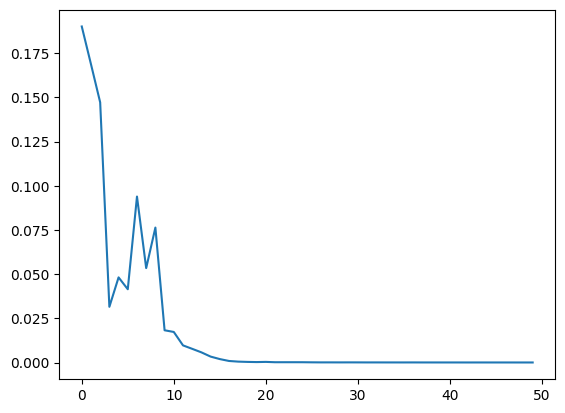

In [18]:
i = 0
print(f'{modelArray[i]} has provided an accuracy of {accuracyArray[i]}')
Y=historyArray[i].history['loss']
plt.plot(range(len(Y)),Y)

<function ResNet152V2 at 0x7ee6d9a0af80> has provided an accuracy of 1.0


Text(0.5, 1.0, 'ResNet152')

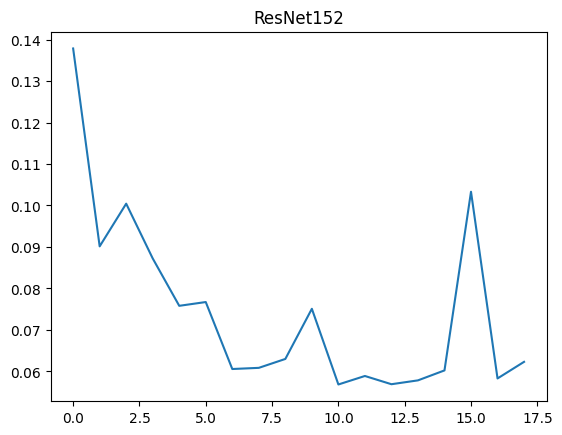

In [19]:
i = 1
print(f'{modelArray[i]} has provided an accuracy of {accuracyArray[i]}')
Y=historyArray[i].history['loss']
plt.plot(range(len(Y)),Y)
plt.title("ResNet152")

<function VGG16 at 0x7ee6d9a0b130> has provided an accuracy of 1.0


Text(0.5, 1.0, '<function VGG16 at 0x7ee6d9a0b130>')

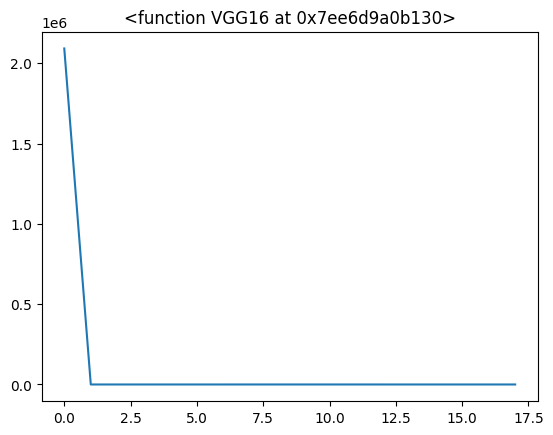

In [20]:
i = 2
print(f'{modelArray[i]} has provided an accuracy of {accuracyArray[i]}')
Y=historyArray[i].history['loss']
plt.plot(range(len(Y)),Y)
plt.title(f"{modelArray[i]}")

<function MobileNet at 0x7ee6d9a08ca0> has provided an accuracy of 1.0


Text(0.5, 1.0, '<function MobileNet at 0x7ee6d9a08ca0>')

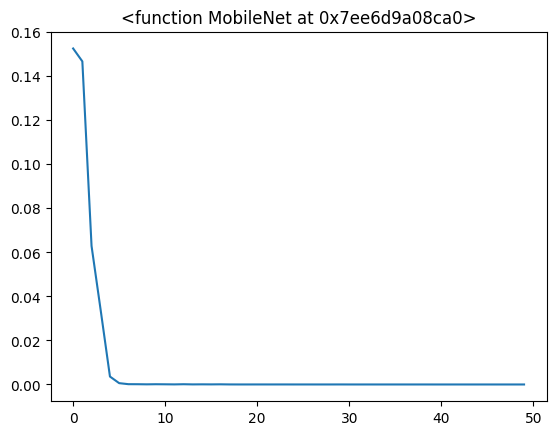

In [21]:
i = 3
print(f'{modelArray[i]} has provided an accuracy of {accuracyArray[i]}')
Y=historyArray[i].history['loss']
plt.plot(range(len(Y)),Y)
plt.title(f"{modelArray[i]}")

In [22]:
historyArray[0]